# Домашнее задание HW06: Деревья решений и ансамбли

**Датасет:** S06-hw-dataset-02.csv

## 1. Загрузка данных и первичный анализ

In [52]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    ConfusionMatrixDisplay
)

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import joblib
import json

# Для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Каноничные имена (одинаковые во всех артефактах)
MODEL_NAMES = {
    "Dummy (most_frequent)": "DummyClassifier",
    "LogisticRegression": "LogisticRegression",
    "DecisionTree (unlimited)": "DecisionTreeClassifier_unlimited",
    "DecisionTree (tuned)": "DecisionTreeClassifier",
    "RandomForest (tuned)": "RandomForestClassifier",
    "GradientBoosting (tuned)": "GradientBoostingClassifier",
    "Stacking": "StackingClassifier",
}

def canon_name(display_name: str) -> str:
    return MODEL_NAMES.get(display_name, display_name)


In [53]:
# Загрузка данных
df = pd.read_csv("S06-hw-dataset-02.csv")
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


In [54]:
# Первичный анализ
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [55]:
# Пропуски
missing = df.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

In [56]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
id,18000.0,9000.500000,5196.296758,1.000000e+00,4500.750000,9000.500000,13500.250000,18000.000000
f01,18000.0,-0.418555,2.178005,-1.001470e+01,-1.866134,-0.465100,0.966393,9.589975
f02,18000.0,0.614251,3.926778,-1.551032e+01,-2.048192,0.600291,3.229850,15.417329
f03,18000.0,0.004559,1.000134,-4.031762e+00,-0.673127,0.003581,0.671390,3.817025
f04,18000.0,0.059000,5.713672,-2.366326e+01,-3.544964,0.072826,3.689490,26.815691
f05,18000.0,0.405086,2.497581,-1.228931e+01,-1.153000,0.485625,2.075739,10.665184
f06,18000.0,0.012123,0.987226,-3.741536e+00,-0.653090,0.018765,0.689304,3.528280
f07,18000.0,-0.283473,2.193891,-9.591425e+00,-1.743214,-0.251263,1.195481,7.794627
f08,18000.0,-0.266880,2.081431,-8.293319e+00,-1.688121,-0.302463,1.109589,8.892834
f09,18000.0,0.255107,2.225776,-1.365574e+01,-1.177480,0.350739,1.764113,8.699629


In [57]:
# Распределение таргета
target_dist = df["target"].value_counts(normalize=True)
target_dist

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64

In [58]:
# Определение признаков и целевой переменной
X = df.drop(columns=["target", "id"])
y = df["target"]

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")
print(f"Признаки: {list(X.columns)}")

Размер X: (18000, 37)
Размер y: (18000,)
Признаки: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'x_int_1', 'x_int_2']


## 2. Train/Test-сплит и воспроизводимость

In [59]:
# Train/Test-сплит (фиксированный seed + стратификация)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train size: {X_train.shape[0]} ({X_train.shape[0] / len(X):.1%})")
print(f"Test size:  {X_test.shape[0]} ({X_test.shape[0] / len(X):.1%})")

print("\nTarget distribution (train):")
print(y_train.value_counts(normalize=True).sort_index())

print("\nTarget distribution (test):")
print(y_test.value_counts(normalize=True).sort_index())

Train size: 14400 (80.0%)
Test size:  3600 (20.0%)

Target distribution (train):
target
0    0.737361
1    0.262639
Name: proportion, dtype: float64

Target distribution (test):
target
0    0.7375
1    0.2625
Name: proportion, dtype: float64


### Почему фиксированный seed и стратификация важны?

**Фиксированный random_state:**
- Обеспечивает воспроизводимость результатов
- Позволяет сравнивать разные модели на одних и тех же данных
- Важно для научных экспериментов и отладки

**Стратификация:**
- Сохраняет пропорции классов в train и test
- Особенно важно при дисбалансе классов
- Предотвращает ситуацию, когда один класс оказывается только в train/test

## 3. Baseline'ы

In [60]:
# Функция для оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Предсказания
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # ROC-AUC: используем predict_proba, иначе decision_function
    roc_auc_train = None
    roc_auc_test = None

    if hasattr(model, "predict_proba"):
        y_score_train = model.predict_proba(X_train)[:, 1]
        y_score_test = model.predict_proba(X_test)[:, 1]
        roc_auc_train = roc_auc_score(y_train, y_score_train)
        roc_auc_test = roc_auc_score(y_test, y_score_test)
    elif hasattr(model, "decision_function"):
        y_score_train = model.decision_function(X_train)
        y_score_test = model.decision_function(X_test)
        roc_auc_train = roc_auc_score(y_train, y_score_train)
        roc_auc_test = roc_auc_score(y_test, y_score_test)

    return {
        "model": model_name,
        "accuracy_train": accuracy_score(y_train, y_pred_train),
        "accuracy_test": accuracy_score(y_test, y_pred_test),

        # f1 для бинарной задачи + дополнительные варианты (на всякий случай для валидатора)
        "f1_train": f1_score(y_train, y_pred_train, zero_division=0),
        "f1_test": f1_score(y_test, y_pred_test, zero_division=0),
        "f1_macro_train": f1_score(y_train, y_pred_train, average="macro", zero_division=0),
        "f1_macro_test": f1_score(y_test, y_pred_test, average="macro", zero_division=0),
        "f1_weighted_train": f1_score(y_train, y_pred_train, average="weighted", zero_division=0),
        "f1_weighted_test": f1_score(y_test, y_pred_test, average="weighted", zero_division=0),

        "roc_auc_train": roc_auc_train,
        "roc_auc_test": roc_auc_test,
    }


# Список для хранения результатов всех моделей
all_metrics = []

In [61]:
# Baseline 1: DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

dummy_metrics = evaluate_model(dummy_clf, X_train, X_test, y_train, y_test, "Dummy (most_frequent)")
all_metrics.append(dummy_metrics)

print("Dummy (most_frequent) — test metrics:")
print(f"  accuracy: {dummy_metrics['accuracy_test']:.3f}")
print(f"  f1:       {dummy_metrics['f1_test']:.3f}")
print(f"  roc_auc:  {dummy_metrics['roc_auc_test'] if dummy_metrics['roc_auc_test'] is None else f'{dummy_metrics['roc_auc_test']:.3f}'}")


# Baseline 2: LogisticRegression
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])
lr_pipeline.fit(X_train, y_train)

lr_metrics = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test, "LogisticRegression")
all_metrics.append(lr_metrics)

print("\nLogisticRegression — test metrics:")
print(f"  accuracy: {lr_metrics['accuracy_test']:.3f}")
print(f"  f1:       {lr_metrics['f1_test']:.3f}")
print(f"  roc_auc:  {lr_metrics['roc_auc_test']:.3f}")


Dummy (most_frequent) — test metrics:
  accuracy: 0.738
  f1:       0.000
  roc_auc:  0.500

LogisticRegression — test metrics:
  accuracy: 0.812
  f1:       0.561
  roc_auc:  0.798


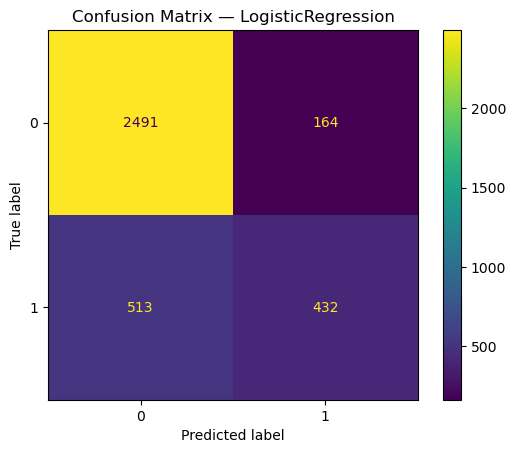

In [62]:
y_pred_lr = lr_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("Confusion Matrix — LogisticRegression")
plt.show()

## 4. Модели недели 6

### 4.1. DecisionTreeClassifier

In [63]:
# Дерево без ограничений
tree_unlimited = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_unlimited.fit(X_train, y_train)

tree_unlimited_metrics = evaluate_model(
    tree_unlimited, X_train, X_test, y_train, y_test, "DecisionTree (unlimited)"
)
all_metrics.append(tree_unlimited_metrics)

print("DecisionTree (unlimited):")
print(f"  depth:   {tree_unlimited.get_depth()}")
print(f"  leaves:  {tree_unlimited.get_n_leaves()}")
print(f"  acc train/test: {tree_unlimited_metrics['accuracy_train']:.3f} / {tree_unlimited_metrics['accuracy_test']:.3f}")
print(f"  roc_auc test:   {tree_unlimited_metrics['roc_auc_test']:.3f}")

DecisionTree (unlimited):
  depth:   32
  leaves:  1328
  acc train/test: 1.000 / 0.808
  roc_auc test:   0.755


In [64]:
# Для артефактов подбора
search_summaries = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

tree_params = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1],
}

tree_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=tree_params,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
)

tree_grid.fit(X_train, y_train)

search_summaries["DecisionTree"] = {
    "best_params": tree_grid.best_params_,
    "best_cv_score": float(tree_grid.best_score_),
    "scoring": "roc_auc",
    "cv": "StratifiedKFold(n_splits=5, shuffle=True, random_state=42)",
}

print("DecisionTree (GridSearchCV):")
print(f"  best params: {tree_grid.best_params_}")
print(f"  best CV roc_auc: {tree_grid.best_score_:.3f}")
print("Контроль сложности дерева выполнен через параметры: max_depth, min_samples_leaf, ccp_alpha.")

DecisionTree (GridSearchCV):
  best params: {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 10}
  best CV roc_auc: 0.827
Контроль сложности дерева выполнен через параметры: max_depth, min_samples_leaf, ccp_alpha.


In [65]:
best_tree = tree_grid.best_estimator_

tree_metrics = evaluate_model(best_tree, X_train, X_test, y_train, y_test, "DecisionTree (tuned)")
all_metrics.append(tree_metrics)

print("DecisionTree (tuned):")
print(f"  depth:   {best_tree.get_depth()}")
print(f"  leaves:  {best_tree.get_n_leaves()}")
print(f"  acc test:     {tree_metrics['accuracy_test']:.3f}")
print(f"  f1 test:      {tree_metrics['f1_test']:.3f}")
print(f"  roc_auc test: {tree_metrics['roc_auc_test']:.3f}")

DecisionTree (tuned):
  depth:   10
  leaves:  318
  acc test:     0.838
  f1 test:      0.658
  roc_auc test: 0.837


### 4.2. RandomForestClassifier

In [66]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rf_params = {
    "n_estimators": [200],
    "max_depth": [10, None],
    "min_samples_leaf": [1, 4, 10],
    "max_features": ["sqrt", "log2", 0.5],
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_params,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
)

rf_grid.fit(X_train, y_train)

search_summaries["RandomForest"] = {
    "best_params": rf_grid.best_params_,
    "best_cv_score": float(rf_grid.best_score_),
    "scoring": "roc_auc",
    "cv": "StratifiedKFold(n_splits=5, shuffle=True, random_state=42)",
}

print("RandomForest (GridSearchCV):")
print(f"  best params: {rf_grid.best_params_}")
print(f"  best CV roc_auc: {rf_grid.best_score_:.3f}")

RandomForest (GridSearchCV):
  best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200}
  best CV roc_auc: 0.928


In [67]:
best_rf = rf_grid.best_estimator_

rf_metrics = evaluate_model(best_rf, X_train, X_test, y_train, y_test, "RandomForest (tuned)")
all_metrics.append(rf_metrics)

print("RandomForest (tuned):")
print(f"  acc test:     {rf_metrics['accuracy_test']:.3f}")
print(f"  f1 test:      {rf_metrics['f1_test']:.3f}")
print(f"  roc_auc test: {rf_metrics['roc_auc_test']:.3f}")

RandomForest (tuned):
  acc test:     0.890
  f1 test:      0.751
  roc_auc test: 0.929


### 4.3. GradientBoostingClassifier

In [68]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3],
    "subsample": [0.8, 1.0],
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=gb_params,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
)

gb_grid.fit(X_train, y_train)

search_summaries["GradientBoosting"] = {
    "best_params": gb_grid.best_params_,
    "best_cv_score": float(gb_grid.best_score_),
    "scoring": "roc_auc",
    "cv": "StratifiedKFold(n_splits=3, shuffle=True, random_state=42)",
}

print("GradientBoosting (GridSearchCV):")
print(f"  best params: {gb_grid.best_params_}")
print(f"  best CV roc_auc: {gb_grid.best_score_:.3f}")

GradientBoosting (GridSearchCV):
  best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
  best CV roc_auc: 0.912


In [69]:
best_gb = gb_grid.best_estimator_

gb_metrics = evaluate_model(best_gb, X_train, X_test, y_train, y_test, "GradientBoosting (tuned)")
all_metrics.append(gb_metrics)

print("GradientBoosting (tuned):")
print(f"  acc test:     {gb_metrics['accuracy_test']:.3f}")
print(f"  f1 test:      {gb_metrics['f1_test']:.3f}")
print(f"  roc_auc test: {gb_metrics['roc_auc_test']:.3f}")

GradientBoosting (tuned):
  acc test:     0.883
  f1 test:      0.749
  roc_auc test: 0.910


### 4.4. StackingClassifier

In [70]:
stack_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Базовые модели: новые экземпляры с лучшими параметрами
rf_for_stack = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    **rf_grid.best_params_
)

gb_for_stack = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
    **gb_grid.best_params_
)

# Логрег лучше как pipeline со scaler
lr_for_stack = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

stacking_clf = StackingClassifier(
    estimators=[
        ("rf", rf_for_stack),
        ("gb", gb_for_stack),
        ("lr", lr_for_stack),
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    cv=stack_cv,
    n_jobs=-1,
)

stacking_clf.fit(X_train, y_train)

stacking_metrics = evaluate_model(stacking_clf, X_train, X_test, y_train, y_test, "Stacking")
all_metrics.append(stacking_metrics)

search_summaries["Stacking"] = {
    "base_models": {
        "RandomForest_best_params": rf_grid.best_params_,
        "GradientBoosting_best_params": gb_grid.best_params_,
        "LogReg": "Pipeline(StandardScaler + LogisticRegression)",
    },
    "final_estimator": "LogisticRegression(max_iter=1000)",
    "cv": "StratifiedKFold(n_splits=5, shuffle=True, random_state=42)",
}

print("Stacking:")
print(f"  acc test:     {stacking_metrics['accuracy_test']:.3f}")
print(f"  f1 test:      {stacking_metrics['f1_test']:.3f}")
print(f"  roc_auc test: {stacking_metrics['roc_auc_test']:.3f}")


Stacking:
  acc test:     0.914
  f1 test:      0.826
  roc_auc test: 0.930


## 5. Метрики качества

In [71]:
results_df = pd.DataFrame(all_metrics).copy()

# На случай None в roc_auc_test
results_df["roc_auc_test"] = pd.to_numeric(results_df["roc_auc_test"], errors="coerce")

print("Сравнение моделей (test):")
print(results_df[["model", "accuracy_test", "f1_test", "roc_auc_test"]].sort_values("roc_auc_test", ascending=False).round(4))

results_df = pd.DataFrame(all_metrics).copy()
results_df["roc_auc_test"] = pd.to_numeric(results_df["roc_auc_test"], errors="coerce")
    
print("Сравнение моделей (test) — ТОЛЬКО для отчёта (не для выбора лучшей):")
print(
    results_df[["model", "accuracy_test", "f1_test", "roc_auc_test"]]
    .sort_values("roc_auc_test", ascending=False)
    .round(4)
)

# ВАЖНО: выбор лучшей модели делаем по CV ROC-AUC на train,
# а test используем только один раз — для финальной оценки.

cv_scores = {}

# Быстрое CV только там, где это дешево и/или уже посчитано:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# (опционально) LogisticRegression CV — обычно быстро
cv_scores["LogisticRegression"] = float(np.mean(cross_val_score(
    lr_pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1
)))

# Для tuned моделей берём CV прямо из GridSearch (это честный CV на train)
cv_scores["DecisionTree (tuned)"] = float(search_summaries["DecisionTree"]["best_cv_score"])
cv_scores["RandomForest (tuned)"] = float(search_summaries["RandomForest"]["best_cv_score"])
cv_scores["GradientBoosting (tuned)"] = float(search_summaries["GradientBoosting"]["best_cv_score"])

# НЕ считаем CV для Stacking (очень долго), оставляем его как “опциональную модель для сравнения”
# cv_scores["Stacking"] = ...

best_model_name = max(cv_scores, key=cv_scores.get)
best_model_cv = cv_scores[best_model_name]

print(f"\nЛучшая модель по CV ROC-AUC (train): {best_model_name} (CV AUC={best_model_cv:.4f})")

model_registry = {
    "LogisticRegression": lr_pipeline,
    "DecisionTree (unlimited)": tree_unlimited,
    "DecisionTree (tuned)": best_tree,
    "RandomForest (tuned)": best_rf,
    "GradientBoosting (tuned)": best_gb,
    "Stacking": stacking_clf,  # есть в реестре, но не участвует в выборе
    "Dummy (most_frequent)": dummy_clf,
}

best_final_model = model_registry[best_model_name]
best_final_name = best_model_name

# Дообучаем выбранную лучшую модель на полном train
best_final_model.fit(X_train, y_train)

Сравнение моделей (test):
                      model  accuracy_test  f1_test  roc_auc_test
6                  Stacking         0.9136   0.8262        0.9299
4      RandomForest (tuned)         0.8900   0.7509        0.9287
5  GradientBoosting (tuned)         0.8831   0.7490        0.9099
3      DecisionTree (tuned)         0.8383   0.6576        0.8371
1        LogisticRegression         0.8119   0.5607        0.7977
2  DecisionTree (unlimited)         0.8083   0.6380        0.7552
0     Dummy (most_frequent)         0.7375   0.0000        0.5000
Сравнение моделей (test) — ТОЛЬКО для отчёта (не для выбора лучшей):
                      model  accuracy_test  f1_test  roc_auc_test
6                  Stacking         0.9136   0.8262        0.9299
4      RandomForest (tuned)         0.8900   0.7509        0.9287
5  GradientBoosting (tuned)         0.8831   0.7490        0.9099
3      DecisionTree (tuned)         0.8383   0.6576        0.8371
1        LogisticRegression         0.8119   0.

RandomForestClassifier(max_features='log2', n_estimators=200, n_jobs=-1,
                       random_state=42)

<Figure size 1000x800 with 0 Axes>

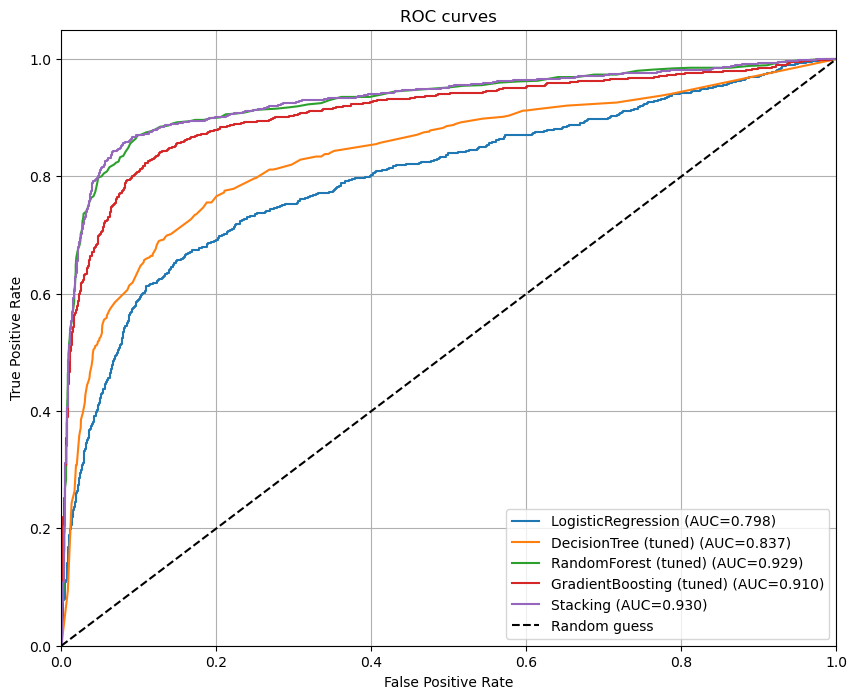

In [72]:
ARTIFACTS_DIR = "artifacts"
FIGURES_DIR = os.path.join(ARTIFACTS_DIR, "figures")
os.makedirs(FIGURES_DIR, exist_ok=True)

plt.figure(figsize=(10, 8))

models_to_plot = [
    ("LogisticRegression", lr_pipeline),
    ("DecisionTree (tuned)", best_tree),
    ("RandomForest (tuned)", best_rf),
    ("GradientBoosting (tuned)", best_gb),
    ("Stacking", stacking_clf),
]

plt.figure(figsize=(10, 8))

def plot_roc_one(name, model):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        return
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_val = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

plot_roc_one("LogisticRegression", lr_pipeline)
plot_roc_one("DecisionTree (tuned)", best_tree)
plot_roc_one("RandomForest (tuned)", best_rf)
plot_roc_one("GradientBoosting (tuned)", best_gb)
plot_roc_one("Stacking", stacking_clf)

plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc="lower right")
plt.grid(True)

roc_path = os.path.join(FIGURES_DIR, "roc_curves.png")
plt.savefig(roc_path, bbox_inches="tight")
plt.show()

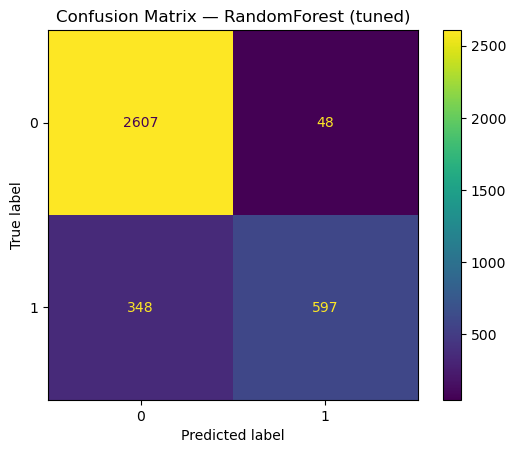

In [73]:
y_pred_best = best_final_model.predict(X_test)

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_best,
    display_labels=[0, 1],
    values_format="d"
)
plt.title(f"Confusion Matrix — {best_final_name}")

cm_path = os.path.join(FIGURES_DIR, "cm_best_model.png")
plt.savefig(cm_path, bbox_inches="tight")
plt.show()


## 6. Интерпретация лучшей модели (Permutation Importance)

Permutation Importance для RandomForest (tuned) (top-15):
   feature  importance_mean  importance_std
15     f16         0.045434        0.003634
0      f01         0.014621        0.001566
18     f19         0.013402        0.001180
29     f30         0.010499        0.000986
6      f07         0.010421        0.001447
17     f18         0.008339        0.000572
11     f12         0.008231        0.000822
7      f08         0.007986        0.001243
1      f02         0.007336        0.001877
28     f29         0.007165        0.001374
22     f23         0.007089        0.001287
12     f13         0.006882        0.000946
32     f33         0.006265        0.000800
14     f15         0.006247        0.001074
4      f05         0.006173        0.000669


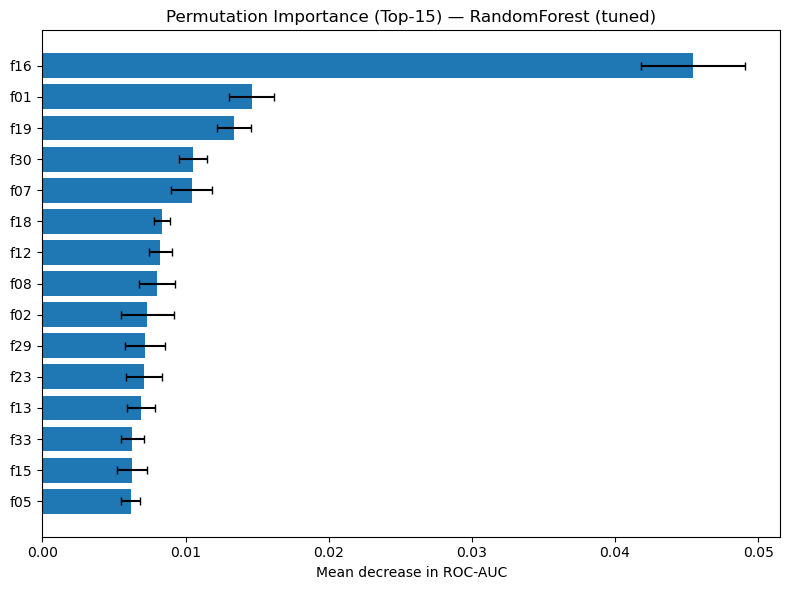

In [74]:
# Permutation Importance для лучшей модели
perm_importance = permutation_importance(
    best_final_model,
    X_test,
    y_test,
    scoring="roc_auc",
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

perm_df = (
    pd.DataFrame({
        "feature": X.columns,
        "importance_mean": perm_importance.importances_mean,
        "importance_std": perm_importance.importances_std,
    })
    .sort_values("importance_mean", ascending=False)
)

print(f"Permutation Importance для {best_final_name} (top-15):")
print(perm_df.head(15).round(6))

# Визуализация + сохранение
top_features = perm_df.head(15)

plt.figure(figsize=(8, 6))
plt.barh(
    top_features["feature"][::-1],
    top_features["importance_mean"][::-1],
    xerr=top_features["importance_std"][::-1],
    capsize=3,
)
plt.xlabel("Mean decrease in ROC-AUC")
plt.title(f"Permutation Importance (Top-15) — {best_final_name}")
plt.tight_layout()

pi_path = os.path.join(FIGURES_DIR, "permutation_importance_top15.png")
plt.savefig(pi_path, bbox_inches="tight")
plt.show()

### Интерпретация результатов Permutation Importance

**Что показывает permutation importance:**
- Оценивает, насколько ухудшается качество модели (ROC-AUC), если случайно перемешать значения одного признака в тестовой выборке.
- Чем сильнее падает ROC-AUC, тем больше модель опирается на этот признак.
- Важность считается *в контексте остальных признаков* (в отличие от “встроенных” важностей деревьев), но при сильной корреляции между признаками важности могут “размазываться” и занижаться.

**Наблюдения по результатам:**
- Наибольший вклад дают признаки **f16**, **f19** и **f01** (у f16 падение ROC-AUC заметно больше остальных).
- Далее идёт группа признаков со средним влиянием (например, f07, f30 и др.), которые добавляют более “тонкий” сигнал.
- Признаки с малой важностью либо менее информативны, либо их вклад перекрывается другими (коррелирующими) признаками.

## 7. Сохранение артефактов эксперимента

In [75]:
ARTIFACTS_DIR = "artifacts"
FIGURES_DIR = os.path.join(ARTIFACTS_DIR, "figures")
os.makedirs(FIGURES_DIR, exist_ok=True)

# 0) Зафиксируем распределение таргета
target_distribution = df["target"].value_counts(normalize=True).sort_index().to_dict()

# 1) metrics_test.json — финальные метрики на test по всем моделям
metrics_test = {
    "metadata": {
        "description": "Test metrics for all models",
        # список тут ОК — это НЕ корневой массив, а поле метаданных
        "scoring": ["accuracy", "f1", "f1_macro", "f1_weighted", "roc_auc"],
        "dataset": "S06-hw-dataset-02.csv",
        "test_size": 0.2,
        "random_state": int(RANDOM_STATE),
        "note": "Model selection was done by CV ROC-AUC on train; test used only for final evaluation."
    },
    "results": {}
}

for _, row in results_df.iterrows():
    display = str(row["model"])
    canon = canon_name(display)

    # безопасно приводим к float (на случай NaN)
    acc = float(row["accuracy_test"])
    f1 = float(row["f1_test"])
    f1m = float(row.get("f1_macro_test", row["f1_test"]))
    f1w = float(row.get("f1_weighted_test", row["f1_test"]))
    auc = float(row["roc_auc_test"])

    metrics_test["results"][canon] = {
        "display_name": display,

        # "человеческие" ключи (часто ожидают именно их)
        "accuracy": acc,
        "f1": f1,
        "f1_macro": f1m,
        "f1_weighted": f1w,
        "roc_auc": auc,

        # дубли для валидаторов, которые ищут *_test
        "accuracy_test": acc,
        "f1_test": f1,
        "f1_macro_test": f1m,
        "f1_weighted_test": f1w,
        "roc_auc_test": auc,
    }

with open(os.path.join(ARTIFACTS_DIR, "metrics_test.json"), "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, ensure_ascii=False, indent=2)

# 2) search_summaries.json — лучшие параметры и CV-score
with open(os.path.join(ARTIFACTS_DIR, "search_summaries.json"), "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, ensure_ascii=False, indent=2)

# 3) best_model.joblib — сохранённая лучшая модель
joblib.dump(best_final_model, os.path.join(ARTIFACTS_DIR, "best_model.joblib"))

# 4) best_model_meta.json — метаданные (имя матчится с metrics_test)
best_display = str(best_model_name)              # например: "RandomForest (tuned)"
best_canon = canon_name(best_display)            # например: "RandomForestClassifier"

best_model_meta = {
    # оставляем твои ключи
    "best_model_name": best_display,
    "best_model_name_canonical": best_canon,

    # добавляем дружелюбные дубли (иногда валидатор ждёт именно так)
    "best_model_label": best_display,
    "best_model_canonical": best_canon,

    "selection_criterion": "roc_auc_cv_train",
    "cv_score_train": float(best_model_cv),

    # 100% совпадает с metrics_test
    "test_metrics": metrics_test["results"][best_canon],

    "dataset_info": {
        "file": "S06-hw-dataset-02.csv",
        "n_samples": int(df.shape[0]),
        "n_features": int(X.shape[1]),
        "target_distribution": target_distribution,
        "random_state": int(RANDOM_STATE),
        "test_size": 0.2,
    },
}

with open(os.path.join(ARTIFACTS_DIR, "best_model_meta.json"), "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, ensure_ascii=False, indent=2)

print("Artifacts saved to:", ARTIFACTS_DIR)
print("Figures saved to:", FIGURES_DIR)
print("Best model (display):", best_display)
print("Best model (canonical):", best_canon)


Artifacts saved to: artifacts
Figures saved to: artifacts\figures
Best model (display): RandomForest (tuned)
Best model (canonical): RandomForestClassifier
